In [118]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import tqdm

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [75]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        policy_arr = np.zeros(nA)
        policy_arr[:] = epsilon/nA
        policy_arr[np.argmax(Q[observation])] += 1 - epsilon
        return policy_arr

    return policy_fn

In [137]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
            
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
             
    for episode in tqdm.tqdm(range(num_episodes)):
        ''' for each state in a sample:
                1. update the number of times we've seen it
                2. update the sum of returns for that state.
        '''
        done = False
        seq = []
        state = env.reset()
        while not done:
            action = np.argmax(policy(state))
            new_state, reward, done, info = env.step(action)
            seq.append([(state, action), reward])
            state = new_state
    
        for step_no in range(len(seq)):
            returns_count[seq[step_no][0]] += 1
            disc = 0
            for next_step in range(step_no, len(seq)):
                returns_sum[seq[step_no][0]] += (discount_factor ** disc) * seq[next_step][1]
                disc += 1

        for (state, action) in returns_count:
            Q[state][action] = returns_sum[(state, action)]/returns_count[(state, action)]
            
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    return Q, policy

In [138]:
#Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [04:14<00:00, 1968.15it/s]


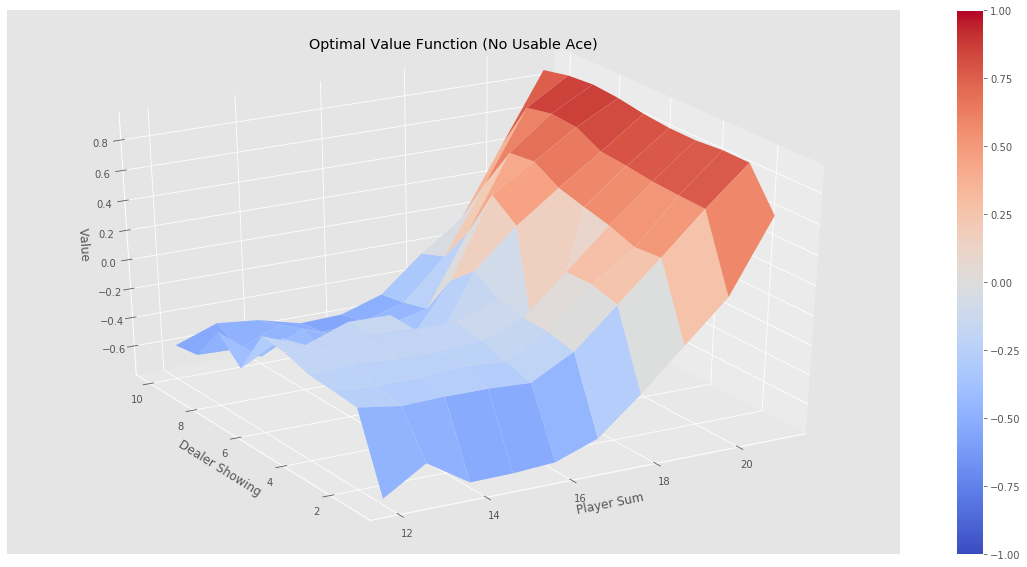

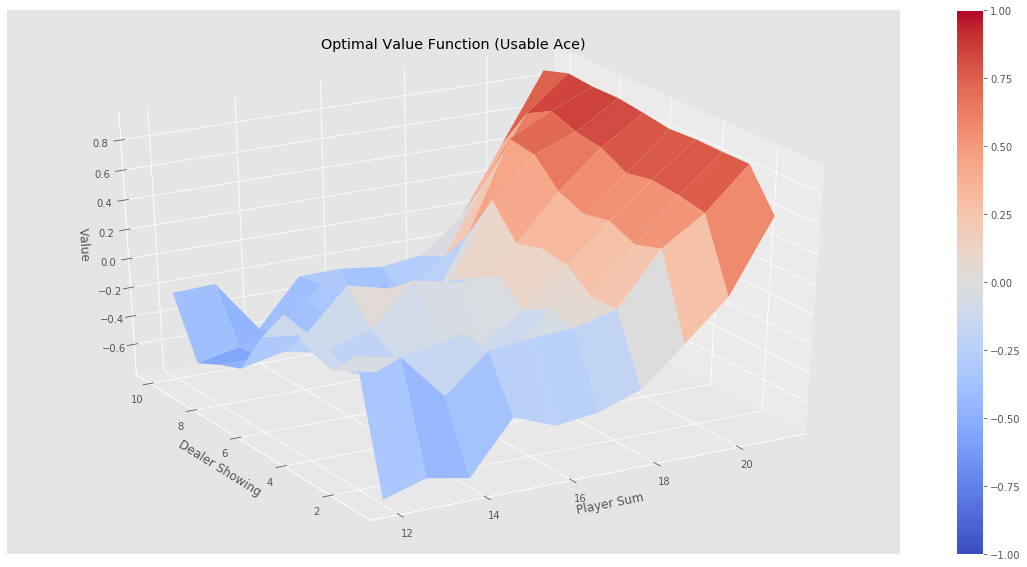

In [139]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")